In [ ]:
import torch
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

from edm.prior import ScorePrior, get_ode_flow, likelihood_fn, ode_sampler
from edm import load_model
import deepinv as dinv

In [2]:
# for better precision
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = False

## Load a pre-trained Score model

We use the CIFAR10 model at 32x32 resolution here. One can change to bigger model if needed.

In [ ]:
device = torch.device('cuda')

# Change to your model name if needed. Eg: "edm-ffhq-64x64-uncond-ve.pkl", "edm-afhqv2-64x64-uncond-vp.pkl", ...
model_name = 'edm-cifar10-32x32-uncond-vp.pkl'  
model = load_model(model_name).to(device)
def denoiser(x, t, *args, **kwargs):
    return model(x.to(torch.float32), t, *args, **kwargs).to(torch.float64)    # Compute in float64 for better precision

prior = ScorePrior(denoiser=denoiser)


Sucessfully loaded the model edm-cifar10-32x32-uncond-vp.pkl
Number of parameters:  55733891


In [30]:
BATCH_SIZE = 4
shape = (BATCH_SIZE, 3, 32, 32)

ode_flow, t_spans = get_ode_flow(prior, "edm")
class_labels = torch.eye(1000, device=device)[torch.randint(10, size=[BATCH_SIZE], device=device)]
def grad_fn(x):
    grad = -prior.scaled_score(x, sigma_denoiser=0.001, class_labels=class_labels)
    return grad
grad_fn_compiled = torch.compile(grad_fn)

In [39]:
def jvp_fn(u, crit):
    return torch.autograd.functional.jvp(
        grad_fn,
        inputs=crit,
        v=u,
        create_graph=False,
    )[1]
def full_hessian_matrix(K, crit):
    e = torch.eye(np.prod(shape[1:]), device=device)[None,:,:].expand(shape[0], -1, -1).view(shape[0], -1, shape[1], shape[2], shape[3])
    hessian = []
    fn = partial(jvp_fn, crit=crit)
    for k in tqdm(range(K)):
        hessian.append(fn(e[:,k,...]))
    return torch.stack(hessian, dim = 1).flatten(2,-1)

## Sample using the ODE flow

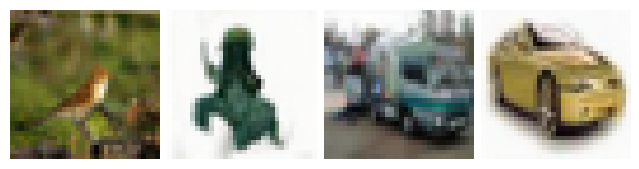

In [32]:
ode_flow, t_spans = get_ode_flow(prior)
ode_sample, nfe = ode_sampler(
    ode_flow, shape=shape, t_spans=t_spans, rtol=1e-6, atol=1e-6
)
dinv.utils.plot([_ for _ in ode_sample], rescale_mode='min_max')

Compute the potential 

In [33]:
potential = likelihood_fn(ode_sample, ode_flow, t_spans=t_spans)
print(potential)

tensor([ -5981.9121, -11196.7617,  -8191.0586,  -9129.4746], device='cuda:0')


Perform gradient descent steps for computing the critical points of the prior

In [26]:
import torchvision

# Load some image from CIFAR10 dataset
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
sample, _ = next(iter(dataloader))
sample = sample.to(device)

100%|██████████| 170M/170M [00:05<00:00, 28.5MB/s] 


In [35]:
from tqdm import tqdm

x = ode_sample.clone()
x_bar = x.clone()
lr = 0.01
pb = tqdm(range(3000))   # Increase if necessary
all_grad_norm = []
for i in pb:
    grad = grad_fn(x_bar)
    x_bar = x_bar - lr * grad

    grad_norm = torch.linalg.norm(grad.view(x_bar.size(0), -1), dim=-1).tolist()
    all_grad_norm.append(grad_norm)
    pb.set_description(f"{grad_norm}")

  0%|          | 0/3000 [00:00<?, ?it/s]

[0.0050838698216471665, 0.004588880121808723, 0.005060602903924188, 0.004862330525587911]: 100%|██████████| 3000/3000 [01:01<00:00, 48.94it/s]  


We can see that the potential is decreased after gradient descent steps

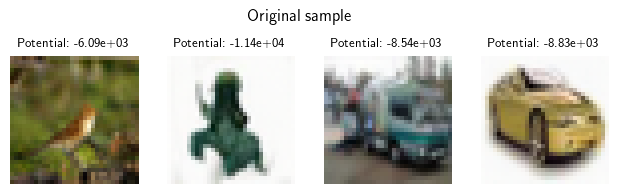

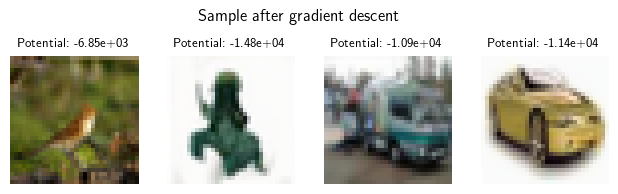

In [36]:
potential = likelihood_fn(x, ode_flow, t_spans=t_spans)
potential_x_bar = likelihood_fn(x_bar, ode_flow, t_spans=t_spans)
dinv.utils.plot([_ for _ in x], titles=[f"Potential: {p:.2e}" for p in potential], rescale_mode='min_max', suptitle='Original sample')
dinv.utils.plot([_ for _ in x_bar], titles=[f"Potential: {p:.2e}" for p in potential_x_bar], rescale_mode='min_max', suptitle='Sample after gradient descent')

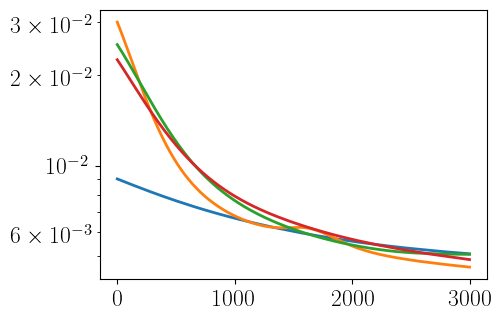

In [37]:
plt.figure(figsize=(5,3.5))
all_grad_norm = np.array(all_grad_norm)
for i in range(all_grad_norm.shape[1]):
    plt.plot(all_grad_norm[:,i])
plt.yscale('log')
plt.show()

## Computing the spectral

In [ ]:
H_data = full_hessian_matrix(3072, crit=x_bar)
svdvals = torch.linalg.svdvals(H_data)

  0%|          | 0/3072 [00:00<?, ?it/s]

100%|██████████| 3072/3072 [26:37<00:00,  1.92it/s]


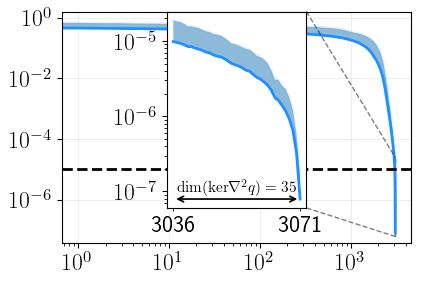

In [47]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import FancyArrowPatch


svdvals = svdvals.cpu().numpy()
svdmean = np.mean(svdvals, axis=0)
svdq = np.quantile(svdvals, q=0.99, axis=0)
svd_index = np.arange(svdmean.shape[0])
eps = 1e-5
color = 'dodgerblue'

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.loglog(svd_index, svdmean, color=color)
ax.loglog(svd_index, svdq, alpha=0.1, color=color)

ax.fill_between(svd_index, svdmean, svdq, alpha=0.5)

ax.axhline(y=eps, linestyle="--", color="black")


start_index = np.min(np.where(svdmean < eps))
x1, x2 = svd_index[start_index], svd_index[-1]  # x-axis range for zoom
y1, y2 = svdmean[start_index], svdmean[-1]      # y-axis range for zoom

# Create an inset axis for the zoomed-in section
axins = inset_axes(ax, width="40%", height="85%", loc="lower center", borderpad=1.5)

axins.loglog(svd_index[start_index:], svdmean[start_index:], color=color)
axins.loglog(svd_index[start_index:], svdq[start_index:], alpha=0.1, color=color)
axins.fill_between(svd_index[start_index:], svdmean[start_index:], svdq[start_index:], alpha=0.5)

axins.set_xticks([x1, x2], minor=True)
axins.set_xticklabels([x1, x2], minor=True)

# Add arrow
x_mid = (x1 + x2) / 2
y_mid = (y1 + y2) / 2
arrow = FancyArrowPatch(
    (x1, y2),
    (x2, y2),
    arrowstyle="<->",
    color="black",
    mutation_scale=10,
    linewidth=1.25,
)
axins.add_patch(arrow)
axins.text(
    x_mid,
    y2 * 1.1,
    rf"$\mathrm{{dim}}(\mathrm{{ker}} \nabla^2 q) = {x2 - x1}$",
    ha="center",
    va="bottom",
    fontsize=11,
    color="black",
)

ax.grid(True, alpha=0.2)
# Connect the inset plot to the main plot
mark_inset(ax, axins, loc1=1, loc2=4, alpha=0.5, linestyle="--", joinstyle="round")
# Show the plot

fig.savefig('./save/spectrum_cifar10.pdf')
plt.show()